## Implementation of NSGA II algorithm
#### Minimizing the lateral and total surface area of a right circular cone subject the constraint r in [0, 10], h in [0, 20] cm and V>200 cm3 
#### Shivji Bhagat - 16110149 - shivji.bhagat@iitgn.ac.in
#### References:
1. https://www.youtube.com/watch?v=Yb82W2Bolqc
2. https://core.ac.uk/download/pdf/30341871.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
###utility functions#####
#function 1
def lateralSA(r,h, pi = 3.143):
    l = (r**2+h**2)**0.5
    return pi*r*l

#funciton 2
def totalSA(r,h, pi = 3.143):
    return lateralSA(r,h) + pi*r**2

#constraint_function
def volume(r, h, pi = 3.143):
    return (1/3)*pi*h*r**2

def flipBit(s, prob):
    assert s in ["0", "1"]
    assert prob in [0,1]
    if prob==1:
        return '1' if s=='0' else '0'
    return s
def applyBounds(x, lower = [0,0], upper = [10,20]):
    #x (float)
    a1 = max(x[0],lower[0])
    a1 = min(x[0], upper[0])
    a2 = max(x[1],lower[1])
    a2 = min(x[1], upper[1])
    y = np.array([a1,a2])
    y = np.around(y,2)
    return y
def applyConstraint(population, limit = 200):
    """
    """
    if (volume(population[:,0],population[:,1])>200).all():
        return population
    newPop = []
    for x in population:
        r,h = x
        if volume(r,h)>limit:
            newPop.append(x)
        else:
            rnew = np.around(np.random.uniform(5, 10), 2)
            hnew = np.around(np.random.uniform(10, 20), 2)
            newPop.append([rnew, hnew])
    return np.array(newPop)

convert2objective = lambda x:np.around(np.array([lateralSA(x[:,0],x[:,1]), totalSA(x[:,0],x[:,1])]).T,2)

In [3]:
def float2binary(parent, nvar, ndec=2, chromosome_size=11):
    """
    Converts each of the nvar values of the parent to binary of size "chromosome_size" and concatenates them
    to 1 string
    Args:
        parent (list) - list of nvar floating values
        nvar (int) - no. of variables, the size of parent
        ndec (int) - max no. of decimal points of each values in parent
        chromosome_size (int) - no. of bits to which each value in parent is converted
    Return:
        parent_bin (str) - binary no. string made by concatenating each value's binary equivalent
    """
    parent_bin = ""
    for i in range(nvar):
        val = int(parent[i]*10**ndec) #converting from float to int, later will be converted back
        binary = bin(val)[2:]
        binary = "0"*(chromosome_size-len(binary)) + binary
        parent_bin = parent_bin + binary
    return parent_bin
def binary2float(child, nvar, ndec=2, chromosome_size=11):
    """
    Converts the child string to nvar float values by reversin the effect of float2binary
    Args:
        child (str) - binary no. string made by concatenating each value's binary equivalent,
                     size - nvar*chromosome_size
        nvar (int) - no. of variables whose binary are concatenated in child
        ndec (int) - max no. of decimal points of each values 
        chromosome_size (int) - no. of bits of each value in child
    Return:
        child (list) - list of nvar floating values
    """
    child_float = []
    
    for i in range(nvar):
        val = child[i*chromosome_size:(i+1)*chromosome_size]
        val = int(val, 2)/10**ndec    #converting to float, reversing the effect of binary conversion
        child_float.append(val)
        
    return child_float

In [4]:
def initialize_population(npop, nvar = 2, var_range = [(0,10), (0,20)], ndecimal = 2, seed = 0):
    """Initializes population and returns it
    Args:
        npop (int)- population size
        nvar (int)- no. of variables in the problem
        var_range (list) - a list of tuples, where ith tuple is the range of values ith variable takes
        ndecimal (int)- max no. digits after decimal points the variables can take, helps in converting to binary
        seed (int)- numpy random seed 
    Return:
        initial_pop (2d-array of size (npop,nvar)) - ith row corresponsds to ith member in population
                                                            which is a list of nvar values
    """
    np.random.seed(seed)
    initial_pop = []
    for i in range(nvar):
        var_size = var_range[i]
        new_member = np.around(np.random.uniform(var_size[0], var_size[1], (1,npop)), 2)
        initial_pop.append(new_member)
    initial_pop = np.array(initial_pop).T
    return initial_pop.squeeze()

In [5]:
def tournament_selection(npop, rank):
    """
    Selects a parent for mating besed on touranment selection
    Args:
        npop (int)- population size
        rank (dict) - a dictionary containing the ranks of each member from current population
    """
    parent1 = np.random.randint(0, npop)
    parent2 = np.random.randint(0, npop)
    
    return (parent1 if rank[parent1]<rank[parent2] else parent2)

In [6]:
def crossover(parent1, parent2, nvar=2, ndec=2, prob = 0.85, chromosome_size = 11):
    """
    Perfroms two point genetic crossover and returns the new children
    NOTE - Does not apply bouds to new child here!
    
    Args:
        parent1, parent2 (list) - parents each containing nvar values
        ndec (int) - max no. of decimal points in values contained in parents
        prob (float) - the probabilty for doing crossover
        chromosome_size (int)- the size of the binary equivalent of largest no. in var_size 
    Return:
        child1, child2 (list)
    """
    parent1_ = float2binary(parent1, nvar, ndec, chromosome_size)
    parent2_ = float2binary(parent2, nvar, ndec, chromosome_size)
    
    crossover_point1 = np.random.randint(2,chromosome_size*nvar//2)
    crossover_point2 = np.random.randint(1+chromosome_size*nvar//2, chromosome_size*nvar-1)
    if np.random.rand()<=prob:
        child1 = parent1_[:crossover_point1] + parent2_[crossover_point1:crossover_point2] + parent1_[crossover_point2:]
        child2 = parent2_[:crossover_point1] + parent1_[crossover_point1:crossover_point2] + parent2_[crossover_point2:]
        
        child1 = binary2float(child1, nvar, ndec, chromosome_size)
        child2 = binary2float(child2, nvar, ndec, chromosome_size)
        return child1, child2
    return parent1, parent2

In [7]:
def mutation(child, nvar = 2, ndec = 2, chromosome_size = 11, mutRate = 0.005):
    """
    Performs mutation on the child by converting it to binary and flipping each bit on prob = mutRate
    NOTE - Does not do applyBounds
    """
    childBin = float2binary(child, nvar = 2, ndec = 2, chromosome_size = 11)
    flip = np.int32(np.random.randn(chromosome_size*nvar)<=mutRate)
    mutChild = ''
    
    for i in range(chromosome_size*nvar):
        mutChild = mutChild + flipBit(childBin[i], flip[i])
    mutChild = binary2float(mutChild, nvar, ndec, chromosome_size)
    return mutChild

In [8]:
def crowdingDistSorting(children, population):
    """
    Sorts the chldren belonging to population acc. to the crowding distance sorting
    NOTE - Works only for 2 obective functions
    Args:
        Children (2D array of size (?,nvar)) - the subset of population belonging to a particular pareto 
                                                which needs to be sorted
        Population (2D array of size (npop, nvar)) - the current population
    Returns : Sorted Children
    """
    
    
    costValArray = convert2objective(population)

    Smax, Tmax = np.max(costValArray, axis = 0)  #surfaceArea, TotalArea
    Smin, Tmin = np.min(costValArray, axis = 0)

    tmpCrowd = []
    
    tmp = np.copy(children)
    #assign inf distance to the extreme points corresponding to all objective functions
    tmp = sorted(children, key=lambda x:lateralSA(population[x][0], population[x][1]))
    tmpCrowd.append((tmp[0] ,float('inf')))
    tmpCrowd.append((tmp[-1], float('inf')))
    min1 = tmp[0]
    max1 = tmp[-1]
    
    tmp = sorted(children, key=lambda x:totalSA(population[x][0], population[x][1]))
    tmpCrowd.append([tmp[0] ,float('inf')])
    tmpCrowd.append([tmp[-1], float('inf')])
    min2 = tmp[0]
    max2 = tmp[-1]
    
    extremes = {min1, min2, max1, max2}
    for idx, val in enumerate(tmp):
        if val in extremes:
            pass
        else:
            dist = abs(lateralSA(population[tmp[idx+1]][0], population[tmp[idx+1]][1])-
                    lateralSA(population[tmp[idx-1]][0], population[tmp[idx-1]][1]))/(Smax-Smin)+abs(
                    totalSA(population[tmp[idx+1]][0], population[tmp[idx+1]][1]) - 
                    totalSA(population[tmp[idx-1]][0], population[tmp[idx-1]][1]))/(Tmax-Tmin)

            tmpCrowd.append([val, dist])
    
    tmpCrowd = np.array(tmpCrowd)
    newChildren = np.array(sorted(tmpCrowd, key = lambda x:x[1], reverse=True)).squeeze()
    newChildren = newChildren[:,0]
    idx = np.unique(newChildren, return_index = True)[1]
    newChildren = [newChildren[i] for i in sorted(idx)]
    return np.int32(newChildren)

In [9]:
def atLeast1dominate(front, x):
    """
    Checks wheather atleast one soln in front dominates soln x
    Args:
        front (list) - list of soln(with cost values) belonging to a front
        x (array) - a solution containing the cost values
    Returns:
        True/ False
    """
    if True in [(i<x).all() for i in front]:
        return True
    return False
def findFront(idx, paretoFronts, costs):
    """
    Returns the front to which the solution[idx] belongs, and simultaneously updates the Pareto front
    Args:
        idx (int) - the index of the solution whose front no. is to be found
        paretoFronts (dict) - the current paretoFronts, to be updated too.
        costs (2D array)- the cost values array corresponding the current population sorted to descending
                            order of 1 cost function (here lateralSA)
    Return:
        front (int) - the front no. to which soln[idx] belongs
    Update:
        paretoFronts (dict) - assigns idx to ParetoFronts[front]
    """
    l = len(paretoFronts)
    if l==0:
        paretoFronts[1] = [idx]
        return 1
    for i in paretoFronts:
        front = paretoFronts[i]
        if atLeast1dominate([costs[t] for t in front], costs[idx])==False:
            paretoFronts[i].append(idx)
            return idx
    paretoFronts[l+1] = [idx]
    return l+1
def nonDominatedSorting(population):
    """
    Perfroms non-dominated sorting on the population and returns the pareto front, along with the population 
    sorted in escending order of lateralSA 
    NOTE - crowding distance sorting not applied here
    """
    nvar = population.shape[1]
    npop = population.shape[0]
    
    populationSorted = np.array(sorted(population, key = lambda x:totalSA(x[0],x[1])))
    costs = convert2objective(populationSorted)
    paretoFronts = {}
    
    for i in range(npop):
        findFront(i, paretoFronts, costs)
    return paretoFronts, populationSorted

def updateRank(paretoFronts):
    """
    Returns the updated rank of each solution
    Args:
        paretoFronts (dict) - current pareto fronts
    Return:
        rank (dict) - rank of each solution idx
    """
    ranks = {}
    r = 1
    for front in paretoFronts:
        for idx in paretoFronts[front]:
            ranks[idx] = r
            r+=1
    return ranks
def updatePopulation(population, paretoFronts, npop):
    newPop = []
    if len(population)<=npop:
        return population
    count=0
    flag = 0
    for front in paretoFronts:
        if flag==1:
            break
        for x in paretoFronts[front]:
            if count>=npop:
                flag=1
                break
            newPop.append(population[x])
            count+=1
    return np.array(newPop)
def plotParetoFronts(paretoFronts, population):
    """
    Plots the pareto fronts from the given pareto front and population data
    """
    costs = convert2objective(population)
    plt.scatter(costs[:,0], costs[:,1])
    for front in paretoFronts:
        cost = np.array([costs[i] for i in paretoFronts[front]])
        S = cost[:,0]
        T = cost[:,1]
        plt.plot(S,T)
        #plt.show()
    plt.xlabel("Lateral Surface Area")
    plt.ylabel("Total Surface Area")
    plt.title("Pareto Fronts")

## NSGA II

In [10]:
def NSGA2(npop = 6, nvar = 2, niter = 100, crossoverProb = 0.95, mutationRate = 0.5,
          var_range = [(0,10), (0,20)],constraintLimit = 200, seed = 0):
    """
    Combines the above functions to implement the algorithm NSGA II
    Returns the final solution population and the pareto front 
    """
    #initialization
    population = initialize_population(npop, nvar, var_range, seed)
    paretoFronts, population = nonDominatedSorting(population)
    rank = updateRank(paretoFronts)
    
    for i in range(niter):
        for j in range(npop//2):
            #selection
            p1 = tournament_selection(npop, rank)
            p2 = tournament_selection(npop, rank)
            #crossover & mutaion
            c1, c2 = crossover(population[p1], population[p2],prob=crossoverProb)
            c1, c2 = mutation(c1, mutRate= mutationRate), mutation(c2, mutRate=mutationRate)
            #applying bounds
            c1, c2 = applyBounds(c1), applyBounds(c2)
            #adding childrent to the population
            population = np.append(population, np.array([c1,c2]), axis = 0)
        
        population = applyConstraint(population, constraintLimit)
        paretoFronts, population = nonDominatedSorting(population)
        for front in paretoFronts:
            if len(paretoFronts[front])>1:
                paretoFronts[front] = crowdingDistSorting(paretoFronts[front], population)
        rank = updateRank(paretoFronts)
        population = updatePopulation(population,paretoFronts, npop)
        paretoFronts, population = nonDominatedSorting(population)
    return paretoFronts, population

In [11]:
#parameters
npop = 10
niter = 1000
crossoverProb = 0.95
mutationRate = 0.5
paretoFronts, population = NSGA2(npop=10, niter = 1000, crossoverProb=crossoverProb, mutationRate=mutationRate)

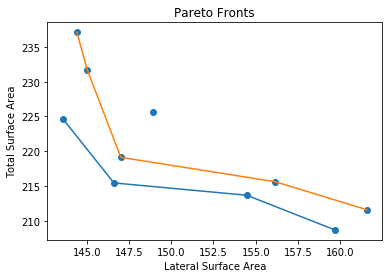

In [12]:
plotParetoFronts(paretoFronts, population)

In [13]:
population

array([[ 3.95, 12.24],
       [ 3.99, 12.25],
       [ 4.34, 10.46],
       [ 4.68,  8.8 ],
       [ 4.35, 10.56],
       [ 4.79,  8.51],
       [ 5.08,  7.42],
       [ 4.94,  8.22],
       [ 5.25,  7.05],
       [ 5.43,  6.49]])

In [14]:
convert2objective(population)

array([[159.67, 208.71],
       [161.57, 211.6 ],
       [154.47, 213.68],
       [146.61, 215.45],
       [156.15, 215.62],
       [147.02, 219.13],
       [143.58, 224.69],
       [148.9 , 225.6 ],
       [145.04, 231.67],
       [144.42, 237.09]])

In [15]:
paretoFronts

{1: [0, 2, 3, 6], 2: [1, 4, 5, 8, 9], 3: [7]}